In [3]:
import fastf1
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import sklearn 
import time 

In [18]:
df = pd.read_csv("dataset/f1_data_combined.csv")

In [20]:
df.head()

,Driver,LapTime_FP1,Compound_FP1,SpeedST_FP1,LongestStintCompound_FP1,LongestStintLaps_FP1,AvgLapTime_LongestStint_FP1,Delta_FirstLastLap_FP1,InvalidLaps_LongestStint_FP1,AvgTyreLife_LongestStint_FP1,...,SafetyCars,VirtualSafetyCars,RaceName,Year,FastestPracticeTime,FastestQualifyingTime,FastestPracticeCompound,IsImputed_FP1,IsImputed_FP2,IsImputed_FP3
0,BOT,90.009,0.0,5.0,0.0,9.0,91.891667,-2.065,6.0,4.666667,...,1.0,4.0,Saudi Arabian Grand Prix,2021,89.019,87.622,0.0,False,False,False
1,GAS,90.263,0.0,2.0,0.0,12.0,92.192800,-2.484,7.0,7.000000,...,1.0,4.0,Saudi Arabian Grand Prix,2021,88.715,88.125,1.0,False,False,False
2,GIO,90.318,0.0,8.0,1.0,10.0,93.519500,-3.016,6.0,6.000000,...,1.0,4.0,Saudi Arabian Grand Prix,2021,89.590,88.616,0.0,False,False,False
3,HAM,89.786,0.0,4.0,0.0,10.0,91.686250,-1.893,6.0,5.500000,...,1.0,4.0,Saudi Arabian Grand Prix,2021,88.314,87.511,2.0,False,False,False
4,LAT,91.821,0.0,4.0,2.0,9.0,92.959667,-2.152,6.0,6.000000,...,1.0,4.0,Saudi Arabian Grand Prix,2021,90.366,89.177,0.0,False,False,False


In [19]:
# REMOVE UNNECESSARY COLUMNS

# Remove unnecessary columns qualifying
colsToDrop = ["Q1_TopSpeedST", "Q1_AirTemp", "Q1_TrackTemp", "Q1_WindSpeed",
    "Q1_WindDirection", "Q1_Humidity", "Q1_Pressure",
    "Q2_TopSpeedST", "Q2_AirTemp", "Q2_TrackTemp", "Q2_WindSpeed",
    "Q2_WindDirection", "Q2_Humidity", "Q2_Pressure",
    "Q3_TopSpeedST", "Q3_AirTemp", "Q3_TrackTemp", "Q3_WindSpeed",
    "Q3_WindDirection", "Q3_Humidity", "Q3_Pressure"]

df.drop(columns=colsToDrop, inplace=True)

# Remove unnecessary columns practice sessions
colsToDrop = ["SpeedFL_FP1", "SpeedI1_FP1", "SpeedI2_FP1",
    "SpeedFL_FP2", "SpeedI1_FP2", "SpeedI2_FP2",
    "SpeedFL_FP3", "SpeedI1_FP3", "SpeedI2_FP3"]

df.drop(columns=colsToDrop, inplace=True)

In [21]:
df.isna().sum()

Driver                        0
LapTime_FP1                  52
Compound_FP1                164
SpeedST_FP1                  68
LongestStintCompound_FP1    334
                           ... 
FastestQualifyingTime        17
FastestPracticeCompound     158
IsImputed_FP1                 0
IsImputed_FP2                 0
IsImputed_FP3                 0
Length: 84, dtype: int64

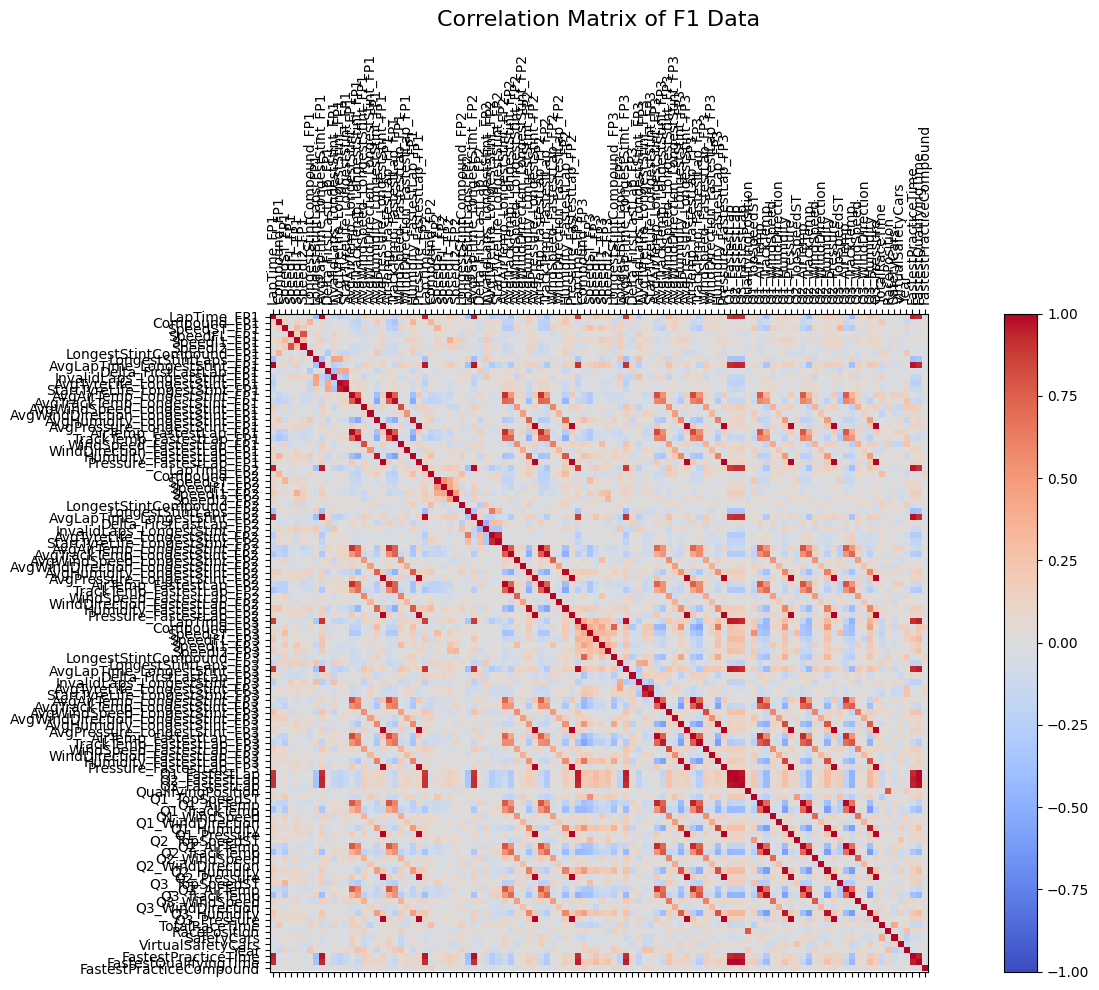

In [7]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
fig, ax = plt.subplots(figsize=(16, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
corr['RacePosition'].sort_values(ascending=True)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title("Correlation Matrix of F1 Data", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

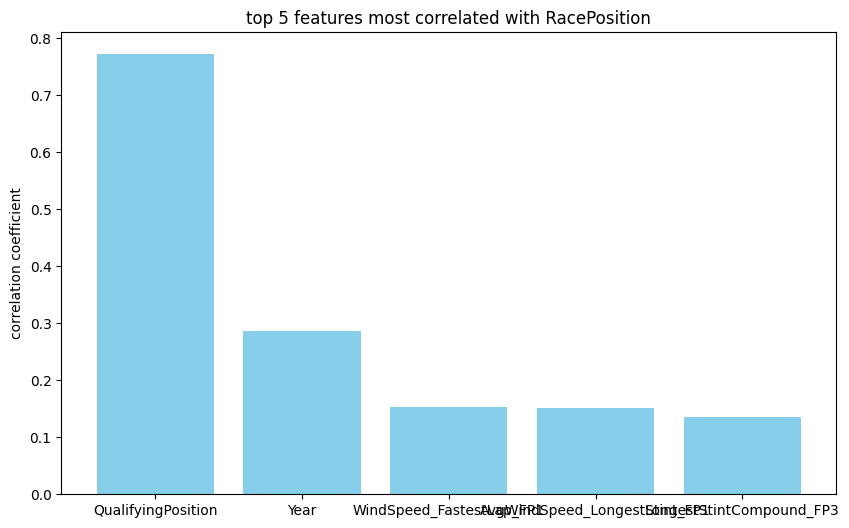

In [8]:
# most correlated features with RacePosition
corr_race = corr["RacePosition"]
corr_race = corr_race.drop("RacePosition")
sorted_corr = corr_race.abs().sort_values(ascending=False)
top5_features = sorted_corr.head(5).index
plt.figure(figsize=(10, 6))
plt.bar(top5_features, corr_race[top5_features], color='skyblue')
plt.ylabel("correlation coefficient")
plt.title("top 5 features most correlated with RacePosition")
plt.show()


In [9]:
# tried keeping only the stronger correlation values 
# there are so many values in the original matrix that it gets confusing
corr = df.corr(numeric_only=True)
threshold = 0.5
filtered_corr = corr.where(corr.abs() > threshold)
print(filtered_corr)


                         LapTime_FP1  Compound_FP1  SpeedST_FP1  SpeedFL_FP1  \
LapTime_FP1                 1.000000           NaN          NaN          NaN   
Compound_FP1                     NaN           1.0          NaN          NaN   
SpeedST_FP1                      NaN           NaN          1.0          NaN   
SpeedFL_FP1                      NaN           NaN          NaN          1.0   
SpeedI1_FP1                      NaN           NaN          NaN          NaN   
...                              ...           ...          ...          ...   
FastestQualifyingTime       0.915218           NaN          NaN          NaN   
FastestPracticeCompound          NaN           NaN          NaN          NaN   
IsImputed_FP1                    NaN           NaN          NaN          NaN   
IsImputed_FP2                    NaN           NaN          NaN          NaN   
IsImputed_FP3                    NaN           NaN          NaN          NaN   

                         SpeedI1_FP1  S

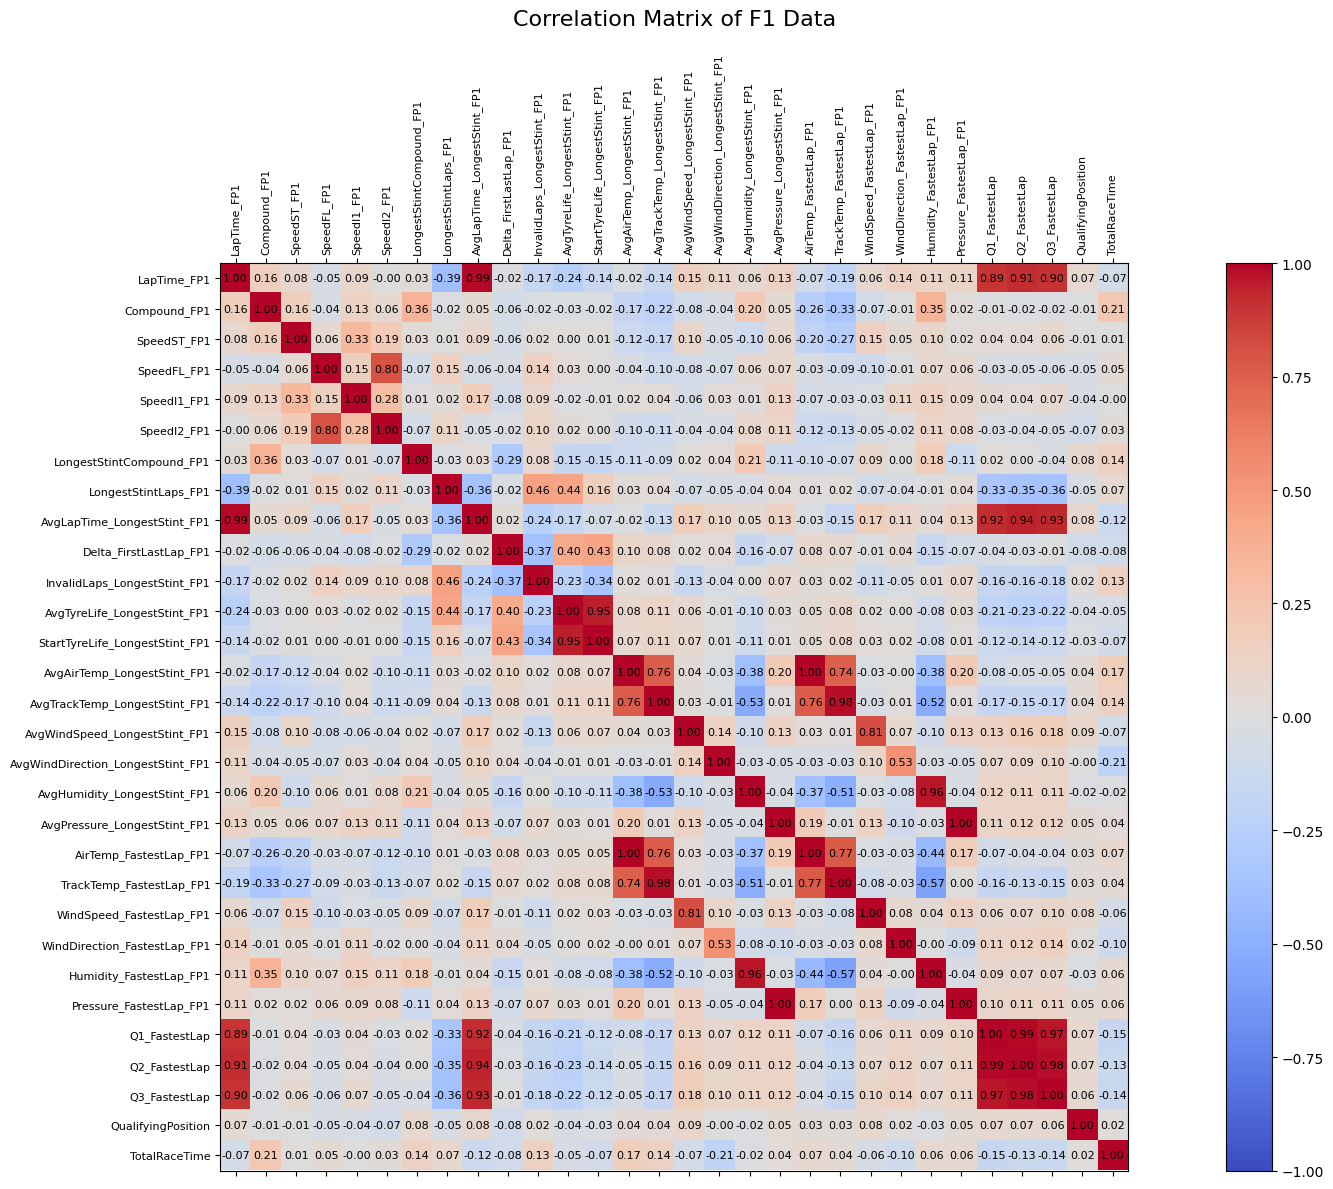

In [10]:
fp1_cols = df.columns[df.columns.str.contains('FP1')].tolist()
q_cols = df.columns[df.columns.str.contains('Q')].tolist()
q_cols_subset = q_cols[:4]
selected_cols = fp1_cols + q_cols_subset
filtered_df = df[selected_cols]
numeric_filtered_df = filtered_df.select_dtypes(include=['number'])
df["TotalRaceTime"] = pd.to_timedelta(df["TotalRaceTime"]).dt.total_seconds()
numeric_filtered_df["TotalRaceTime"] = df["TotalRaceTime"]


corr = numeric_filtered_df.corr()
fig, ax = plt.subplots(figsize=(20, 12))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize = 8)
ax.set_yticklabels(corr.columns, fontsize = 8)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", va='center', ha='center', color='black', fontsize=8)
plt.title("Correlation Matrix of F1 Data", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [11]:
corr_race = corr["RacePosition"]  
corr_race = corr_race.drop("RacePosition")  

sorted_corr = corr_race.abs().sort_values(ascending=False)
top5_features = sorted_corr.head(5).index 

plt.figure(figsize=(10, 6))
plt.bar(top5_features, corr_race[top5_features], color='skyblue')
plt.ylabel("Correlation Coefficient")
plt.title("Top 5 Features Most Correlated with RacePosition")
plt.show()

KeyError: 'RacePosition'